In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from sklearn.datasets import make_blobs
X,Y = make_blobs(n_samples = 1000, n_features=2, centers=3)

### Applying Preprocessing to the data to make it zero mean, unit variance

In [8]:
df = pd.DataFrame({'X':X[:,0], 'Y':X[:,1]})

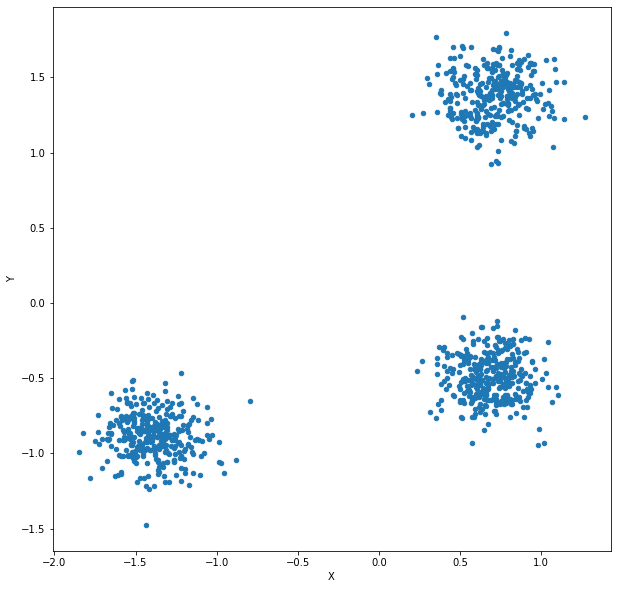

In [9]:
from sklearn.preprocessing import StandardScaler

df = df.dropna()

cols = list(df.columns)

for column in cols:
    df[column] = StandardScaler().fit_transform(df[[column]])

df.plot.scatter(x=cols[0], y=cols[1], figsize=(10,10))

 ### 2. Calculate the LOF score for each point  
      Assuming points having an LOF score greater than 1.5 to be outliers and mapping them in orange color

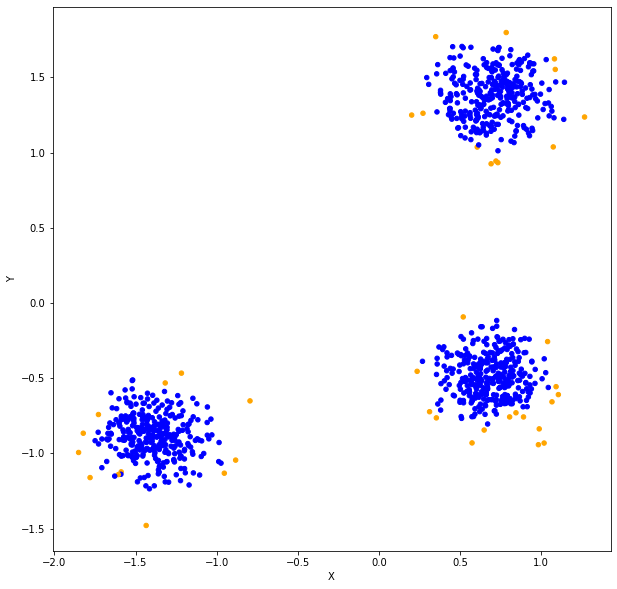

In [10]:
from sklearn.neighbors import LocalOutlierFactor

loc = LocalOutlierFactor(n_neighbors=10)
loc.fit(df)

df['LOF Score'] = loc.negative_outlier_factor_*(-1)
df['Outlier'] = loc.fit_predict(df)

df['color'] = df['LOF Score'].map(lambda x: 'orange' if x>=1.5 else 'blue')
ax1 = df.plot.scatter(x=cols[0], y=cols[1], c=df['color'],figsize=(10,10))

### Calculate Density around each point using KDE

In [11]:
from sklearn.neighbors import LocalOutlierFactor, KernelDensity, NearestNeighbors

kde = KernelDensity()
kde.fit(df[cols])
df['kde'] = kde.score_samples(df[cols])

### Plotting the density field

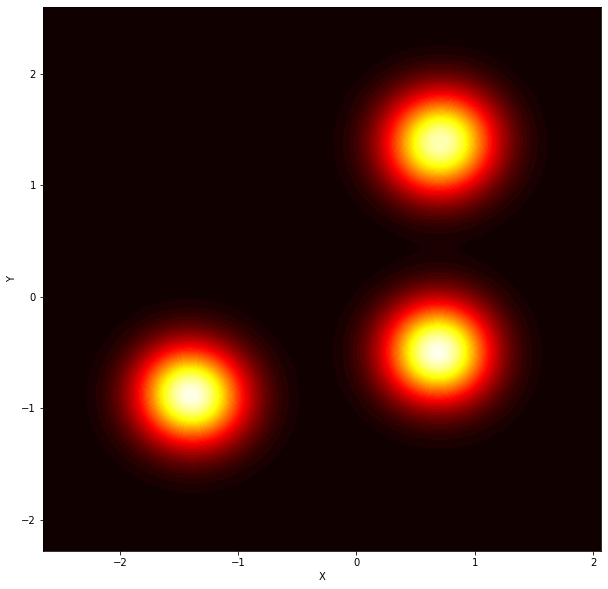

In [12]:
fig = plt.figure(figsize=(10,10))
sns.kdeplot(df[cols[0]], df[cols[1]], cmap='hot', n_levels=60, shade=True)

In [13]:
df['dens_X'] = [0]*len(df)
df['dens_Y'] = [0]*len(df)
df['dens_dist'] = [0]*len(df)
df['X_new'] = [0]*len(df)
df['Y_new'] = [0]*len(df)

### Calculate Density peaks (points with top 10% highest density values - Yellow color)

In [14]:
N_NEIGHBORS = 5

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

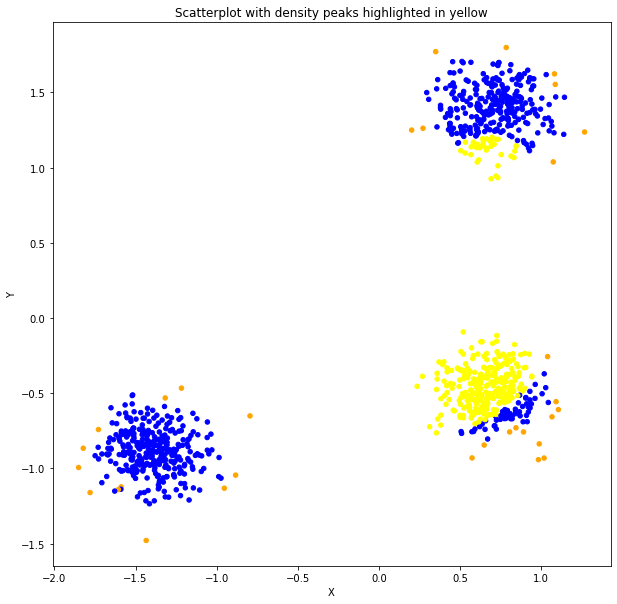

In [21]:
# Transform metric values (LOF, Density)

# Calculate density peaks
# Currently set them to top 10% highest kde density points

threshold = np.percentile(df['kde'], 90)

# Calculate all points with density field greater than this value

peaks = df[df['kde']>=threshold]
df['color'] = df.apply(lambda x: 'yellow' if x['kde']>=threshold else x['color'], axis=1)
peaks = peaks[cols].to_numpy()

df.plot.scatter(x=cols[0], y=cols[1], c=df['color'],figsize=(10,10),
                title="Scatterplot with density peaks highlighted in yellow")

# Train a nearest neighbors model to assign datapoints their nearest density peak 
peaks_nn = NearestNeighbors(n_neighbors=N_NEIGHBORS)
peaks_nn.fit(peaks)

### Steps to apply the transformation:
    1. For each datapoint, calculate the nearest density peak (Using the Nearest Neighbor - currently considering one              nearest neighbor - object we trained before)
    2. Calculate a translation vector for the point which will have a direction towards the nearest density peak assigned          to it and a magnitude which will be calculated based on three factors:
       - KDE density of the point
       - LOF score of the point
       - Distance of the point from the assigned density peak
       
       The magnitude of the vector can either turn out to be positive (towards the density peak) - mostly in case of              inliers, or negative (away from the density peak). 
    3. The idea behind producing this distortion is that inliers will be pushed towards the density peaks to create a              highly dense datapoint cluster and the outliers will be pushed far away from the cluster which will make them more          visible
    4. This transformation can also be applied to any arbitrary point given its coordinates 

### Demonstration of the transformation vectors calculated

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 594.71it/s]


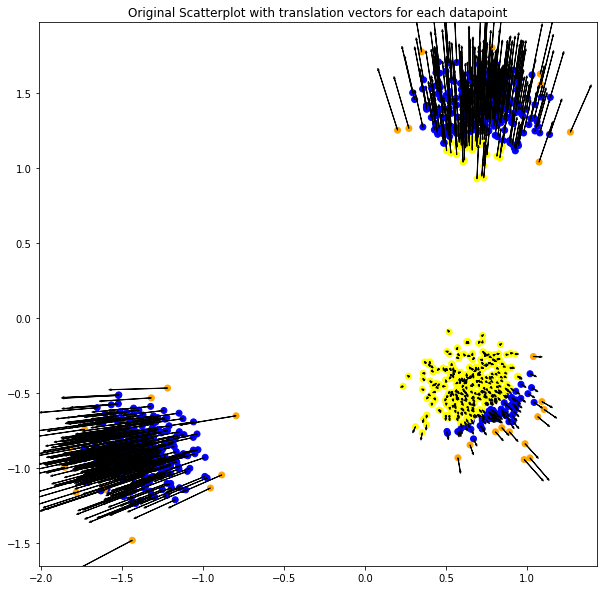

In [23]:
fig = plt.figure(figsize=(10,10))
plt.scatter(df[cols[0]], df[cols[1]], c=df['color'])

for i in tqdm(range(len(df))):
    
    # Assigning the nearest neighbor density peak to each point and calculating the distance 
    
    distance, index = peaks_nn.kneighbors(df[cols].iloc[i].to_numpy().reshape(1,-1))
#     print('Distance : {}\n index: {}\n'.format(distance, index))
    
    distances = distance[0]
    indexes = index[0]
    
    dx,dy=0,0
    
    # Getting the X and Y directions towards the density peaks and adding them
    
    x = df[cols[0]].iloc[i]
    y = df[cols[1]].iloc[i]
    
    for peak_ind in indexes:
        
        curr_peak = peaks[peak_ind,:]
        
        dx += curr_peak[0] - x
        dy += curr_peak[1] - y
    
    # Scaling the magnitude of the vector (can experiment with more mathematical formulations)
    
    # Here, the idea is :
    # - The higher the density, the more the point gets pulled towards the density peak
    # - The higher the outlier score, the more the point gets pushed out (hence, -ve sign)
    # - Similarly, farther away the point from the density peak, the more it gets pushed out
    
    scale = df['kde'].iloc[i]-df['LOF Score'].iloc[i]*10-distance[0][0]
    
    dx *= scale
    dy *= scale
    
    df['X_new'].iloc[i] = df[cols[0]].iloc[i]+dx
    df['Y_new'].iloc[i] = df[cols[1]].iloc[i]+dy
    
    plt.arrow(df[cols[0]].iloc[i],
              df[cols[1]].iloc[i],
              
              # Dividing the scale by 200 for better visibility
              dx/500,
              dy/500,
              
              length_includes_head=True,
              width=0.001 , head_width=0.01)
    
    plt.title("Original Scatterplot with translation vectors for each datapoint")

plt.show()

#### We can observe  in the above graph that the outliers have higher 'push' and inliers have minimal translation - according to our intentions  

####  Producing the transformation according to this scheme

Text(0.5, 1.0, 'Transformed Data')

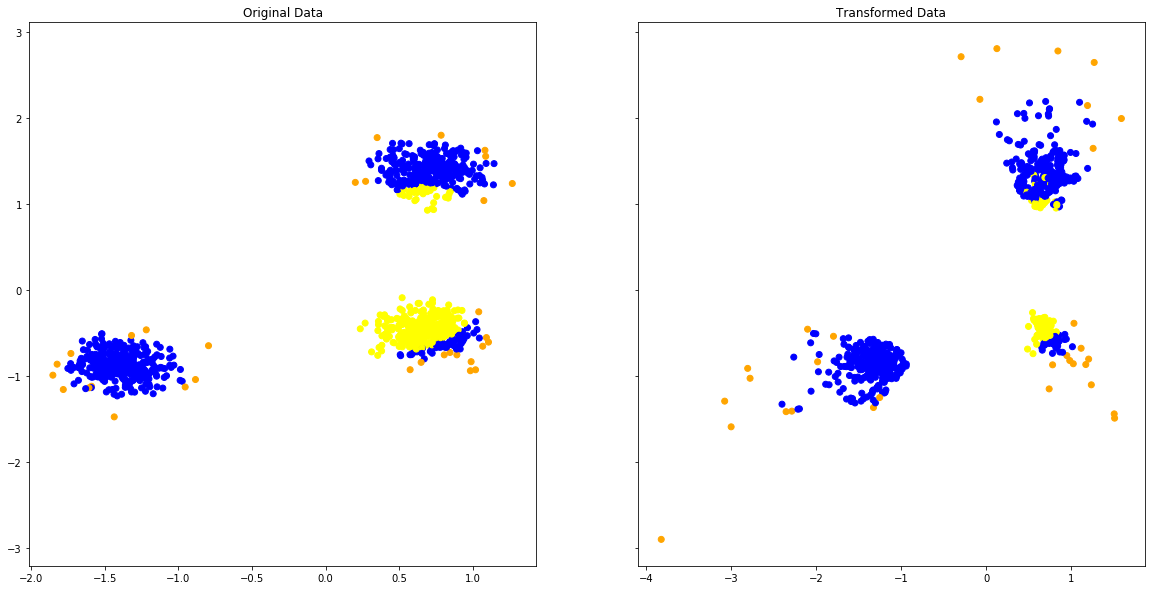

In [24]:
df['X_new'] = StandardScaler().fit_transform(df[['X_new']])
df['Y_new'] = StandardScaler().fit_transform(df[['Y_new']])

new_cols = ['X_new', 'Y_new']

fig, ax = plt.subplots(1,2, figsize=(20,10),sharex='col', sharey='row')

ax[0].scatter(df[cols[0]], df[cols[1]], c=df['color'])
ax[0].set_title('Original Data')
ax[1].scatter(df[new_cols[0]], df[new_cols[1]], c=df['color'])
ax[1].set_title('Transformed Data')

### Another mathematical formulation

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 582.21it/s]


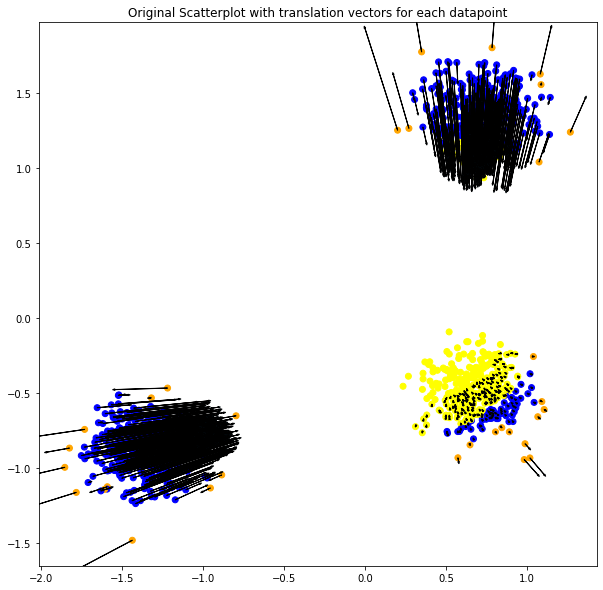

In [29]:
fig = plt.figure(figsize=(10,10))
plt.scatter(df[cols[0]], df[cols[1]], c=df['color'])

for i in tqdm(range(len(df))):
    
    # Assigning the nearest neighbor density peak to each point and calculating the distance 
    
    distance, index = peaks_nn.kneighbors(df[cols].iloc[i].to_numpy().reshape(1,-1))
#     print('Distance : {}\n index: {}\n'.format(distance, index))
    
    distances = distance[0]
    indexes = index[0]
    
    dx,dy=0,0
    
    # Getting the X and Y directions towards the density peaks and adding them
    
    x = df[cols[0]].iloc[i]
    y = df[cols[1]].iloc[i]
    
    for peak_ind in indexes:
        
        curr_peak = peaks[peak_ind,:]
        
        dx += curr_peak[0] - x
        dy += curr_peak[1] - y
    
    # Scaling the magnitude of the vector (can experiment with more mathematical formulations)
    
    # Here, the idea is :
    # - The higher the density, the more the point gets pulled towards the density peak
    # - The higher the outlier score, the more the point gets pushed out (hence, -ve sign)
    # - Similarly, farther away the point from the density peak, the more it gets pushed out
    
    scale = ((df['LOF Score'].iloc[i]-1.5)*distance[0][0])/df['kde'].iloc[i]
    
    dx *= scale
    dy *= scale
    
    df['X_new'].iloc[i] = df[cols[0]].iloc[i]+dx
    df['Y_new'].iloc[i] = df[cols[1]].iloc[i]+dy
    
    plt.arrow(df[cols[0]].iloc[i],
              df[cols[1]].iloc[i],
              
              # Dividing the scale by 200 for better visibility
              dx/5,
              dy/5,
              
              length_includes_head=True,
              width=0.001, head_width=0.01)
    
    plt.title("Original Scatterplot with translation vectors for each datapoint")

plt.show()

Text(0.5, 1.0, 'Transformed Data')

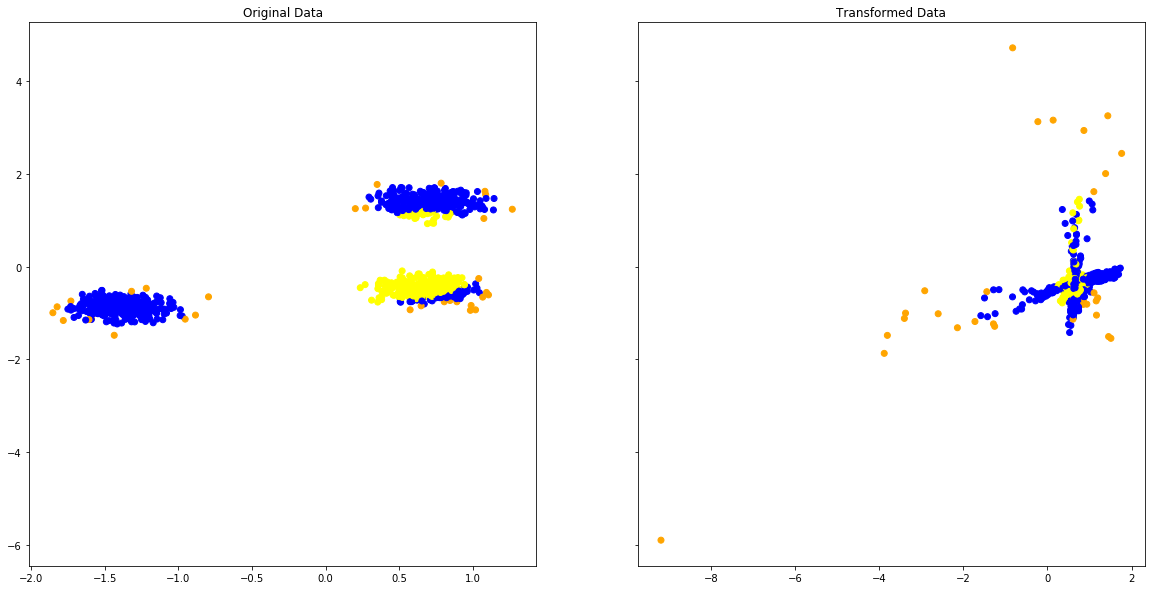

In [30]:
fig, ax = plt.subplots(1,2, figsize=(20,10),sharex='col', sharey='row')

ax[0].scatter(df[cols[0]], df[cols[1]], c=df['color'])
ax[0].set_title('Original Data')
ax[1].scatter(df[new_cols[0]], df[new_cols[1]], c=df['color'])
ax[1].set_title('Transformed Data')